In [2]:
## install packages
import subprocess
import sys

def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])

install('cv2')
install('ultralytics')
install('matplotlib')

In [23]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import random

In [33]:
# Input:
test_data_folder = r'C:\Users\skmmg\Downloads\Test_data'

# Output:
output_folder = 'Test_results'

os.makedirs(output_folder, exist_ok=True)

In [29]:
def crop_image(img, desired_shape):
    
    crop1_start = int((img.shape[0] - desired_shape[0])/2)  
    crop1_end =  img.shape[0] - desired_shape[0] - crop1_start

    crop2_start = int((img.shape[1] - desired_shape[1])/2)
    crop2_end =  img.shape[1] - desired_shape[1] - crop2_start

    pad = [[crop1_start,crop1_end], [crop2_start,crop2_end]]

    if crop1_end < 1:
        crop1_end = -img.shape[0]

    if crop2_end < 1:
        crop2_end = -img.shape[1]
    
    new_image = img[crop1_start:-crop1_end, crop2_start: -crop2_end,:]    
    return new_image, pad


def combine_masks(masks):
  # Create a blank image
  combined_mask = np.zeros((masks.shape[1], masks.shape[2], 3), dtype=np.uint8)

  # Generate a list of random colors
  colors = []
  for _ in range(len(masks)):
    colors.append((random.randint(5, 255), random.randint(5, 255), random.randint(5, 255)))

  # Assign a color to each mask and draw it on the combined mask
  for i, mask in enumerate(masks):
    combined_mask[:,:,0] = combined_mask[:,:,0]+ colors[i][0]*mask
    combined_mask[:,:,1] = combined_mask[:,:,1]+ colors[i][1]*mask
    combined_mask[:,:,2] = combined_mask[:,:,2]+ colors[i][2]*mask

  return combined_mask

def remove_small_overlapping_masks(mask_cpu, overlap_threshold = 0.8):

    masks_size = [mask_cpu[i,:,:].sum() for i in range(mask_cpu.shape[0])]
    overlap_matrix = np.zeros((mask_cpu.shape[0],mask_cpu.shape[0] ))
    masks_to_remove = []

    for i in range(mask_cpu.shape[0]):
        for j in range(mask_cpu.shape[0]):
            overlap_matrix[i,j] = (mask_cpu[i]*mask_cpu[j]).sum()/ mask_cpu[i].sum()
            if i==j:
                overlap_matrix[i,j]  = 0

    high_overlap_idx = np.where(overlap_matrix> overlap_threshold)

    for i in range(len(high_overlap_idx[0])):
        if masks_size[high_overlap_idx[0][i]] >  masks_size[high_overlap_idx[1][i]]:
            masks_to_remove.append(high_overlap_idx[1][i])
        else:
            masks_to_remove.append(high_overlap_idx[0][i])

    new_masks = np.delete(mask_cpu, masks_to_remove, axis=0)
    removed_masks = mask_cpu[masks_to_remove]
    print(mask_cpu.shape[0], new_masks.shape[0], removed_masks.shape[0])
    return new_masks,removed_masks

In [26]:
test_imgs = [img for img in os.listdir(test_data_folder) if '.png' in img]
model= YOLO("Seg_model_ep200.pt")

In [27]:
model_output_shape = (896, 928)

  0%|          | 0/68 [00:00<?, ?it/s]


0: 896x928 59 leafs, 1156.3ms
Speed: 21.1ms preprocess, 1156.3ms inference, 55.1ms postprocess per image at shape (1, 3, 896, 928)


C:\Users\skmmg\AppData\Local\Temp\ipykernel_624\1107494828.py:46: RuntimeWarning: invalid value encountered in scalar divide
  overlap_matrix[i,j] = (mask_cpu[i]*mask_cpu[j]).sum()/ mask_cpu[i].sum()


59 47 17


  1%|▏         | 1/68 [00:25<28:26, 25.48s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 52 leafs, 1157.3ms
Speed: 20.0ms preprocess, 1157.3ms inference, 50.0ms postprocess per image at shape (1, 3, 896, 928)
52 46 16


  3%|▎         | 2/68 [00:41<21:47, 19.81s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 47 leafs, 1083.0ms
Speed: 23.0ms preprocess, 1083.0ms inference, 45.0ms postprocess per image at shape (1, 3, 896, 928)
47 39 13


  4%|▍         | 3/68 [00:54<18:13, 16.83s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 42 leafs, 1200.1ms
Speed: 22.0ms preprocess, 1200.1ms inference, 39.0ms postprocess per image at shape (1, 3, 896, 928)
42 36 7


  6%|▌         | 4/68 [01:06<15:45, 14.77s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 30 leafs, 1074.9ms
Speed: 20.0ms preprocess, 1074.9ms inference, 29.6ms postprocess per image at shape (1, 3, 896, 928)
30 27 4


  7%|▋         | 5/68 [01:13<12:37, 12.03s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 52 leafs, 1124.2ms
Speed: 18.4ms preprocess, 1124.2ms inference, 49.8ms postprocess per image at shape (1, 3, 896, 928)
52 45 8


  9%|▉         | 6/68 [01:28<13:27, 13.02s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 58 leafs, 1079.8ms
Speed: 20.1ms preprocess, 1079.8ms inference, 56.1ms postprocess per image at shape (1, 3, 896, 928)
58 52 6


 10%|█         | 7/68 [01:46<14:52, 14.63s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 50 leafs, 1126.0ms
Speed: 25.1ms preprocess, 1126.0ms inference, 46.0ms postprocess per image at shape (1, 3, 896, 928)
50 49 1


 12%|█▏        | 8/68 [02:00<14:30, 14.51s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 39 leafs, 1116.6ms
Speed: 20.8ms preprocess, 1116.6ms inference, 39.1ms postprocess per image at shape (1, 3, 896, 928)
39 29 16


 13%|█▎        | 9/68 [02:10<12:54, 13.13s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 35 leafs, 1199.8ms
Speed: 22.6ms preprocess, 1199.8ms inference, 36.0ms postprocess per image at shape (1, 3, 896, 928)
35 27 10


 15%|█▍        | 10/68 [02:20<11:47, 12.20s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 35 leafs, 1101.7ms
Speed: 21.1ms preprocess, 1101.7ms inference, 36.3ms postprocess per image at shape (1, 3, 896, 928)
35 32 4


 16%|█▌        | 11/68 [02:30<10:45, 11.32s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 42 leafs, 1107.4ms
Speed: 23.7ms preprocess, 1107.4ms inference, 39.0ms postprocess per image at shape (1, 3, 896, 928)
42 35 13


 18%|█▊        | 12/68 [02:41<10:34, 11.33s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 34 leafs, 1151.2ms
Speed: 19.0ms preprocess, 1151.2ms inference, 33.5ms postprocess per image at shape (1, 3, 896, 928)
34 31 5


 19%|█▉        | 13/68 [02:51<09:55, 10.82s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 37 leafs, 1185.4ms
Speed: 20.0ms preprocess, 1185.4ms inference, 36.9ms postprocess per image at shape (1, 3, 896, 928)
37 33 6


 21%|██        | 14/68 [03:02<09:48, 10.90s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 41 leafs, 1112.8ms
Speed: 24.0ms preprocess, 1112.8ms inference, 38.0ms postprocess per image at shape (1, 3, 896, 928)
41 36 7


 22%|██▏       | 15/68 [03:13<09:49, 11.12s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 41 leafs, 1166.3ms
Speed: 21.2ms preprocess, 1166.3ms inference, 55.7ms postprocess per image at shape (1, 3, 896, 928)
41 37 7


 24%|██▎       | 16/68 [03:27<10:16, 11.86s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 25 leafs, 1174.6ms
Speed: 21.0ms preprocess, 1174.6ms inference, 28.0ms postprocess per image at shape (1, 3, 896, 928)
25 22 5


 25%|██▌       | 17/68 [03:35<09:01, 10.61s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 40 leafs, 1107.0ms
Speed: 24.0ms preprocess, 1107.0ms inference, 37.7ms postprocess per image at shape (1, 3, 896, 928)
40 38 3


 26%|██▋       | 18/68 [03:48<09:26, 11.34s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 27 leafs, 1124.8ms
Speed: 24.0ms preprocess, 1124.8ms inference, 32.0ms postprocess per image at shape (1, 3, 896, 928)
27 25 2


 28%|██▊       | 19/68 [03:58<08:57, 10.96s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 26 leafs, 1170.8ms
Speed: 25.5ms preprocess, 1170.8ms inference, 28.0ms postprocess per image at shape (1, 3, 896, 928)
26 23 3


 29%|██▉       | 20/68 [04:07<08:15, 10.32s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 29 leafs, 1093.0ms
Speed: 20.0ms preprocess, 1093.0ms inference, 28.3ms postprocess per image at shape (1, 3, 896, 928)
29 27 2


 31%|███       | 21/68 [04:17<08:02, 10.26s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 27 leafs, 1114.1ms
Speed: 23.0ms preprocess, 1114.1ms inference, 27.0ms postprocess per image at shape (1, 3, 896, 928)
27 25 4


 32%|███▏      | 22/68 [04:28<08:07, 10.60s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 34 leafs, 1116.4ms
Speed: 25.0ms preprocess, 1116.4ms inference, 33.2ms postprocess per image at shape (1, 3, 896, 928)
34 31 3


 34%|███▍      | 23/68 [04:41<08:32, 11.39s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 42 leafs, 1103.0ms
Speed: 18.4ms preprocess, 1103.0ms inference, 39.1ms postprocess per image at shape (1, 3, 896, 928)
42 36 8


 35%|███▌      | 24/68 [04:56<09:04, 12.38s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 45 leafs, 1128.0ms
Speed: 29.0ms preprocess, 1128.0ms inference, 42.6ms postprocess per image at shape (1, 3, 896, 928)
45 39 12


 37%|███▋      | 25/68 [05:12<09:40, 13.49s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 41 leafs, 1166.5ms
Speed: 26.0ms preprocess, 1166.5ms inference, 38.5ms postprocess per image at shape (1, 3, 896, 928)
41 38 6


 38%|███▊      | 26/68 [05:26<09:28, 13.54s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 21 leafs, 1102.9ms
Speed: 24.0ms preprocess, 1102.9ms inference, 21.0ms postprocess per image at shape (1, 3, 896, 928)
21 18 4


 40%|███▉      | 27/68 [05:34<08:09, 11.93s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 15 leafs, 1087.4ms
Speed: 25.0ms preprocess, 1087.4ms inference, 81.2ms postprocess per image at shape (1, 3, 896, 928)
15 14 2


 41%|████      | 28/68 [05:41<06:56, 10.42s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 18 leafs, 1178.4ms
Speed: 21.8ms preprocess, 1178.4ms inference, 19.0ms postprocess per image at shape (1, 3, 896, 928)
18 17 1


 43%|████▎     | 29/68 [05:48<06:13,  9.57s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 23 leafs, 1122.2ms
Speed: 21.9ms preprocess, 1122.2ms inference, 23.4ms postprocess per image at shape (1, 3, 896, 928)
23 20 5


 44%|████▍     | 30/68 [05:57<05:49,  9.21s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 10 leafs, 1113.4ms
Speed: 21.0ms preprocess, 1113.4ms inference, 12.0ms postprocess per image at shape (1, 3, 896, 928)
10 9 1


 46%|████▌     | 31/68 [06:03<05:07,  8.32s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 28 leafs, 1071.8ms
Speed: 22.0ms preprocess, 1071.8ms inference, 30.0ms postprocess per image at shape (1, 3, 896, 928)
28 24 8


 47%|████▋     | 32/68 [06:13<05:14,  8.74s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 28 leafs, 1173.4ms
Speed: 19.5ms preprocess, 1173.4ms inference, 28.2ms postprocess per image at shape (1, 3, 896, 928)
28 25 3


 49%|████▊     | 33/68 [06:23<05:18,  9.11s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 30 leafs, 1192.8ms
Speed: 22.0ms preprocess, 1192.8ms inference, 29.2ms postprocess per image at shape (1, 3, 896, 928)
30 25 7


 50%|█████     | 34/68 [06:33<05:26,  9.60s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 15 leafs, 1200.8ms
Speed: 23.9ms preprocess, 1200.8ms inference, 22.0ms postprocess per image at shape (1, 3, 896, 928)
15 13 4


 51%|█████▏    | 35/68 [06:41<05:01,  9.13s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 12 leafs, 1169.9ms
Speed: 21.3ms preprocess, 1169.9ms inference, 13.0ms postprocess per image at shape (1, 3, 896, 928)
12 10 3


 53%|█████▎    | 36/68 [06:49<04:34,  8.58s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 16 leafs, 1193.7ms
Speed: 20.6ms preprocess, 1193.7ms inference, 17.6ms postprocess per image at shape (1, 3, 896, 928)
16 15 2


 54%|█████▍    | 37/68 [06:57<04:21,  8.44s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 14 leafs, 1108.2ms
Speed: 21.3ms preprocess, 1108.2ms inference, 17.1ms postprocess per image at shape (1, 3, 896, 928)
14 14 0


 56%|█████▌    | 38/68 [07:05<04:10,  8.33s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 17 leafs, 1085.9ms
Speed: 24.0ms preprocess, 1085.9ms inference, 17.5ms postprocess per image at shape (1, 3, 896, 928)
17 17 0


 57%|█████▋    | 39/68 [07:13<04:03,  8.39s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 20 leafs, 1199.9ms
Speed: 22.0ms preprocess, 1199.9ms inference, 20.6ms postprocess per image at shape (1, 3, 896, 928)
20 18 6


 59%|█████▉    | 40/68 [07:23<04:02,  8.66s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 29 leafs, 1175.8ms
Speed: 19.5ms preprocess, 1175.8ms inference, 29.0ms postprocess per image at shape (1, 3, 896, 928)
29 26 5


 60%|██████    | 41/68 [07:34<04:17,  9.54s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 24 leafs, 1084.0ms
Speed: 25.0ms preprocess, 1084.0ms inference, 24.0ms postprocess per image at shape (1, 3, 896, 928)
24 23 1


 62%|██████▏   | 42/68 [07:45<04:18,  9.95s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 25 leafs, 1174.9ms
Speed: 21.0ms preprocess, 1174.9ms inference, 24.0ms postprocess per image at shape (1, 3, 896, 928)
25 21 7


 63%|██████▎   | 43/68 [07:56<04:15, 10.21s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 38 leafs, 1080.0ms
Speed: 19.0ms preprocess, 1080.0ms inference, 37.0ms postprocess per image at shape (1, 3, 896, 928)
38 31 11


 65%|██████▍   | 44/68 [08:11<04:36, 11.51s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 39 leafs, 1085.5ms
Speed: 25.0ms preprocess, 1085.5ms inference, 39.0ms postprocess per image at shape (1, 3, 896, 928)
39 33 10


 66%|██████▌   | 45/68 [08:26<04:53, 12.77s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 46 leafs, 1088.9ms
Speed: 24.1ms preprocess, 1088.9ms inference, 43.0ms postprocess per image at shape (1, 3, 896, 928)
46 37 18


 68%|██████▊   | 46/68 [08:45<05:20, 14.55s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 49 leafs, 1070.6ms
Speed: 24.0ms preprocess, 1070.6ms inference, 47.2ms postprocess per image at shape (1, 3, 896, 928)
49 39 20


 69%|██████▉   | 47/68 [09:04<05:35, 15.99s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 49 leafs, 1112.9ms
Speed: 22.0ms preprocess, 1112.9ms inference, 47.0ms postprocess per image at shape (1, 3, 896, 928)
49 42 11


 71%|███████   | 48/68 [09:24<05:40, 17.05s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 56 leafs, 1188.3ms
Speed: 27.2ms preprocess, 1188.3ms inference, 50.9ms postprocess per image at shape (1, 3, 896, 928)
56 49 10


 72%|███████▏  | 49/68 [09:47<05:59, 18.92s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 79 leafs, 1105.0ms
Speed: 24.0ms preprocess, 1105.0ms inference, 145.0ms postprocess per image at shape (1, 3, 896, 928)
79 68 16


 74%|███████▎  | 50/68 [10:25<07:23, 24.66s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 59 leafs, 1084.6ms
Speed: 21.9ms preprocess, 1084.6ms inference, 56.2ms postprocess per image at shape (1, 3, 896, 928)
59 50 13


 75%|███████▌  | 51/68 [10:50<07:00, 24.73s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 60 leafs, 1076.3ms
Speed: 23.1ms preprocess, 1076.3ms inference, 59.0ms postprocess per image at shape (1, 3, 896, 928)
60 51 13


 76%|███████▋  | 52/68 [11:17<06:47, 25.49s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 42 leafs, 1106.7ms
Speed: 20.0ms preprocess, 1106.7ms inference, 45.2ms postprocess per image at shape (1, 3, 896, 928)
42 38 6


 78%|███████▊  | 53/68 [11:34<05:41, 22.77s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 69 leafs, 1175.3ms
Speed: 21.0ms preprocess, 1175.3ms inference, 63.0ms postprocess per image at shape (1, 3, 896, 928)
69 62 8


 79%|███████▉  | 54/68 [12:00<05:33, 23.84s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 48 leafs, 1199.3ms
Speed: 21.0ms preprocess, 1199.3ms inference, 45.0ms postprocess per image at shape (1, 3, 896, 928)
48 44 5


 81%|████████  | 55/68 [12:18<04:46, 22.05s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 31 leafs, 1114.4ms
Speed: 19.0ms preprocess, 1114.4ms inference, 30.0ms postprocess per image at shape (1, 3, 896, 928)
31 29 3


 82%|████████▏ | 56/68 [12:30<03:49, 19.12s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 40 leafs, 1169.0ms
Speed: 20.0ms preprocess, 1169.0ms inference, 37.0ms postprocess per image at shape (1, 3, 896, 928)
40 34 8


 84%|████████▍ | 57/68 [12:45<03:16, 17.88s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 57 leafs, 1176.3ms
Speed: 20.0ms preprocess, 1176.3ms inference, 53.0ms postprocess per image at shape (1, 3, 896, 928)
57 47 18


 85%|████████▌ | 58/68 [13:07<03:09, 18.90s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 55 leafs, 1154.3ms
Speed: 19.0ms preprocess, 1154.3ms inference, 51.9ms postprocess per image at shape (1, 3, 896, 928)
55 50 8


 87%|████████▋ | 59/68 [13:28<02:57, 19.72s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 85 leafs, 1179.3ms
Speed: 21.0ms preprocess, 1179.3ms inference, 103.9ms postprocess per image at shape (1, 3, 896, 928)
85 67 31


 88%|████████▊ | 60/68 [14:05<03:18, 24.79s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 26 leafs, 1175.3ms
Speed: 19.0ms preprocess, 1175.3ms inference, 26.0ms postprocess per image at shape (1, 3, 896, 928)
26 22 6


 90%|████████▉ | 61/68 [14:17<02:26, 20.97s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 49 leafs, 1127.4ms
Speed: 20.0ms preprocess, 1127.4ms inference, 46.0ms postprocess per image at shape (1, 3, 896, 928)
49 48 1


 91%|█████████ | 62/68 [14:36<02:01, 20.28s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 70 leafs, 1185.3ms
Speed: 20.0ms preprocess, 1185.3ms inference, 65.0ms postprocess per image at shape (1, 3, 896, 928)
70 61 10


 93%|█████████▎| 63/68 [15:03<01:52, 22.53s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 41 leafs, 1184.3ms
Speed: 19.0ms preprocess, 1184.3ms inference, 39.0ms postprocess per image at shape (1, 3, 896, 928)
41 39 2


 94%|█████████▍| 64/68 [15:20<01:22, 20.66s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 42 leafs, 1125.4ms
Speed: 22.0ms preprocess, 1125.4ms inference, 40.0ms postprocess per image at shape (1, 3, 896, 928)
42 37 6


 96%|█████████▌| 65/68 [15:37<00:58, 19.65s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 98 leafs, 1142.4ms
Speed: 19.0ms preprocess, 1142.4ms inference, 117.9ms postprocess per image at shape (1, 3, 896, 928)
98 80 23


 97%|█████████▋| 66/68 [16:24<00:55, 27.82s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 102 leafs, 1110.4ms
Speed: 22.0ms preprocess, 1110.4ms inference, 123.9ms postprocess per image at shape (1, 3, 896, 928)
102 86 25


 99%|█████████▊| 67/68 [17:13<00:34, 34.28s/it]

(896, 941, 3) (896, 941, 3)

0: 896x928 89 leafs, 1103.4ms
Speed: 23.0ms preprocess, 1103.4ms inference, 81.0ms postprocess per image at shape (1, 3, 896, 928)
89 78 22


100%|██████████| 68/68 [17:53<00:00, 15.79s/it]

(896, 941, 3) (896, 941, 3)


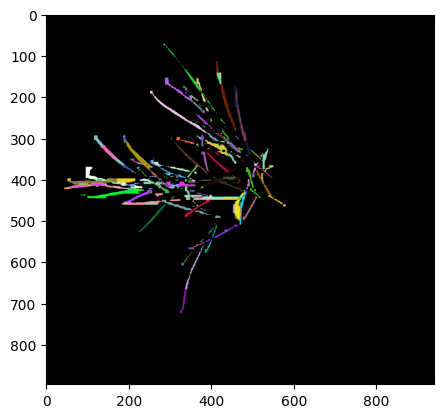

In [35]:
for img_name in tqdm(test_imgs):
    
    image_path = os.path.join(test_data_folder,img_name)
    img = cv2.imread(image_path)
    

    croped_image, pads = crop_image(img, model_output_shape)

    results1 =  model.predict(croped_image)
    masks = results1[0].masks.data
    mask_cpu = masks.cpu().numpy()

    masks_resized = np.array([ np.pad(mask, pads, 'constant', constant_values=0) for mask in mask_cpu])

    masks_processed, removed = remove_small_overlapping_masks(masks_resized, overlap_threshold=0.8)
    predicted_image = np.zeros(masks_processed.shape[1:3])
    predicted_image =  combine_masks(masks_processed)
    
    plt.imshow(predicted_image)
    plt.savefig(os.path.join(Output_folder,img_name))
    print(img.shape, predicted_image.shape )

    